# xG vs actual goals

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import matplotlib.gridspec as gridspec
import matplotlib.text as mtext
from matplotlib.offsetbox import AnchoredText
import numpy as np

from PIL import Image
import urllib
import json
import os

# Read data into dataframes to manipulate

In [139]:
path_to_json_matches = r'C:\Users\al.eriksson\Documents\Python\Football\ettan\matchdata' 
path_to_json_minutesdata = r'C:\Users\al.eriksson\Documents\Python\Football\ettan\playerdata'

# find all .json extensions in a specific directory and assign to one of two lists (matches, players)
json_files_matches = [pos_json for pos_json in os.listdir(path_to_json_matches) if pos_json.endswith('.json')]
json_file_minutesdata = [pos_json for pos_json in os.listdir(path_to_json_minutesdata) if pos_json.endswith('.json')]

In [140]:
# Collect all matches from directory in a dataframe
all_matches = []

for i in list(range(0, len(json_files_matches))):
    file_path = r'C:\Users\al.eriksson\Documents\Python\Football\ettan\matchdata' + '/' + json_files_matches[i]
    with open(file_path) as file:
        data = json.load(file)
        match_date = data['date']  # Extract the date for the current match
        events = data['events']  # Extract the events for the current match
        for event in events:
            event['date'] = match_date # Add 'date' to the events df
        all_matches.extend(events)  # Append the modified events to the list

all_matches_df = pd.DataFrame(all_matches)  # Convert the list of dictionaries to DataFrame


# Collect the ID for a specific tournament and match
dir = r'C:\Users\al.eriksson\Documents\Python\Football\ettan\playerdata'
f = open (dir + '/' + json_file_minutesdata[0])
minutesdata = json.loads(f.read())
minutesdata = pd.DataFrame(minutesdata)

In [141]:
# type convert the 'date' column from string to date format
all_matches_df['date'] = pd.to_datetime(all_matches_df['date']).dt.date

# Ensure full player names are present (e.g. "A. Murray" becomes "Andy Murray)

In [142]:
# rename the minutesdata name column to player
minutesdata = minutesdata.rename(columns={'name': 'player'})
# Create a dictionary to map nicknames to player names, excluding None or Null 'friendly_name'
nickname_map = minutesdata.dropna(subset=['friendly_name']).set_index('friendly_name')['player'].to_dict()

# Replace nicknames with player names in all_matches_df only if 'friendly_name' is not None or NULL
all_matches_df['player'] = all_matches_df.apply(lambda row: nickname_map.get(row['player']) if row['player'] in nickname_map else row['player'], axis=1)

# Drop records without "xg" values. Create two dfs from goals and shots

In [143]:
all_matches_df = all_matches_df.dropna(subset=['xg'])
goal_df = all_matches_df[all_matches_df['action'] == 'Goal']
shot_df = all_matches_df[all_matches_df['action'] == 'Shot']

# Sum up the goals + xg and calculate the difference

In [144]:
# From the goal_df we sum up the total amount of goals, and then the xg from each goal
# From the shot_df we sum up the total xg from each shot

# Calculate the sum of goals for each player, team, and date
goals_sum = goal_df.groupby(['player', 'team', 'date'])['action'].count().reset_index()
goals_sum.rename(columns={'action': 'goals'}, inplace=True)

# Calculate the sum of xG from goals for each player, team, and date
xg_goals_sum = goal_df.groupby(['player', 'team', 'date'])['xg'].sum().reset_index()
xg_goals_sum.rename(columns={'xg': 'xg_goals'}, inplace=True)

# Calculate the sum of xG from shots for each player, team, and date
xg_shots_sum = shot_df.groupby(['player', 'team', 'date'])['xg'].sum().reset_index()
xg_shots_sum.rename(columns={'xg': 'xg_shots'}, inplace=True)

# Merge the calculated sums into the player_df
player_df = pd.merge(goals_sum, xg_goals_sum, on=['player', 'team', 'date'], how='outer')
player_df = pd.merge(player_df, xg_shots_sum, on=['player', 'team', 'date'], how='outer')

# Drop all NaN-values
player_df.fillna(0, inplace=True)

# Create an 'xG' column that is the sum of 'xg_goals' and 'xg_shots'
player_df['xG'] = player_df['xg_goals'] + player_df['xg_shots'] 

# Calculate the difference between 'goals' and 'xG'
player_df['difference'] = player_df['goals'] - player_df['xG']
player_df.sort_values(by='difference', ascending=False)

,player,team,date,goals,xg_goals,xg_shots,xG,difference
339,Noel Wågberg,IFK Stocksund,2023-05-12,3.0,0.271082,0.000000,0.271082,2.728918
346,Oliver Åkerman,Eskilsminne IF,2023-06-11,3.0,0.548139,0.179567,0.727707,2.272293
152,Erik Björndahl,IF Karlstad Fotboll,2023-04-16,2.0,0.121081,0.000000,0.121081,1.878919
51,Alibek Aliev,Trollhättan,2023-05-07,2.0,0.189182,0.000000,0.189182,1.810818
170,Fredrik Johansson,Piteå IF FF,2023-05-13,2.0,0.202437,0.012157,0.214594,1.785406
...,...,...,...,...,...,...,...,...
1389,Johan Albin,Eskilsminne IF,2023-06-05,0.0,0.000000,1.127868,1.127868,-1.127868
2404,Wanbe Godwin Aguda,Falkenbergs FF,2023-05-01,0.0,0.000000,1.136321,1.136321,-1.136321
2187,Samuel Dawid Rydz,Täby FK,2023-05-12,0.0,0.000000,1.145362,1.145362,-1.145362
6,Abdulmannan Khalil,Sollentuna FK,2023-05-18,1.0,0.411697,1.744572,2.156269,-1.156269


# Sum up xG, goals, and the difference for a player in a specific team

In [145]:
sum_diff_player_df_1 = player_df.groupby(['player', 'team'])['difference'].sum().reset_index()
sum_goals_player_df_1 = player_df.groupby(['player', 'team'])['goals'].sum().reset_index()
sum_xg_player_df_1 = player_df.groupby(['player', 'team'])['xG'].sum().reset_index()
sum_diff_player_df = sum_diff_player_df_1.merge(sum_goals_player_df_1, on=['player', 'team'])
sum_diff_player_df = sum_diff_player_df.merge(sum_xg_player_df_1, on=['player', 'team'])

# function that takes the timeline of xG and actual goals so we can plot a time series.

In [146]:
def get_player_goals_xg_df(player, data=player_df):
    df = data.copy()
    player_data = df[df['player'] == player][['player', 'team', 'date', 'goals', 'xG']].reset_index(drop=True)
    player_data.columns = ['player', 'team', 'date', 'goals', 'xG']
    player_data['cum_goals'] = player_data['goals'].cumsum()
    player_data['cum_xG'] = player_data['xG'].cumsum()
    player_data['cum_difference'] = player_data['cum_goals'] - player_data['cum_xG']
    return player_data


# The viz

In [147]:
def plot_goals_difference(ax, player, label_y=False, data=player_df):
    ax.grid(ls='--', color='lightgrey', alpha=0.3)  # Set the alpha value to 0.3
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_edgecolor('lightgrey')
    ax.spines['bottom'].set_edgecolor('lightgrey')
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.tick_params(color='lightgrey', labelsize=8, labelcolor='grey')
    test_df = get_player_goals_xg_df(player, data)
    index_values = np.ravel(test_df.index.to_numpy()) + 1

    ax.plot(index_values, test_df['cum_goals'].values, marker='o', mfc='white', ms=5, color='#287271')
    ax.plot(index_values, test_df['cum_xG'].values, marker='o', mfc='white', ms=5, color='#D81159')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    max_value = max(test_df['cum_goals'].max(), test_df['cum_xG'].max())
    ax.set_ylim(-1, max_value + 2)  # Set y-axis limit dynamically based on the maximum value
    ax.set_xlim(0.25)
    ax.set_xticklabels([])
    # Determine a reference mid-point and the difference between xG and goals
    mid_point = test_df['cum_goals'].iloc[-1] + (test_df['cum_xG'].iloc[-1] - test_df['cum_goals'].iloc[-1]) / 2
    difference = test_df['cum_goals'].iloc[-1] - test_df['cum_xG'].iloc[-1]
    text_ = ax.annotate(
        xy=(ax.get_xlim()[1], mid_point),
        text=f'{difference:.1f}',
        xytext=(-5, 0),
        ha='center',
        va='center',
        color='#D81159',
        weight='bold',
        size=7,
        textcoords='offset points'
    )
    text_.set_path_effects(
        [path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()]
    )
    # ----------------------------------------------------------------
    if label_y:
        ax.set_ylabel('Goals', color='grey', size=8)
    else:
        ax.set_yticklabels([])


# Choose a player

Plotting graph for Alibek Aliev (Trollhättan)
Cumulative xG for Alibek Aliev: 5.7
Cumulative goals for Alibek Aliev: 13


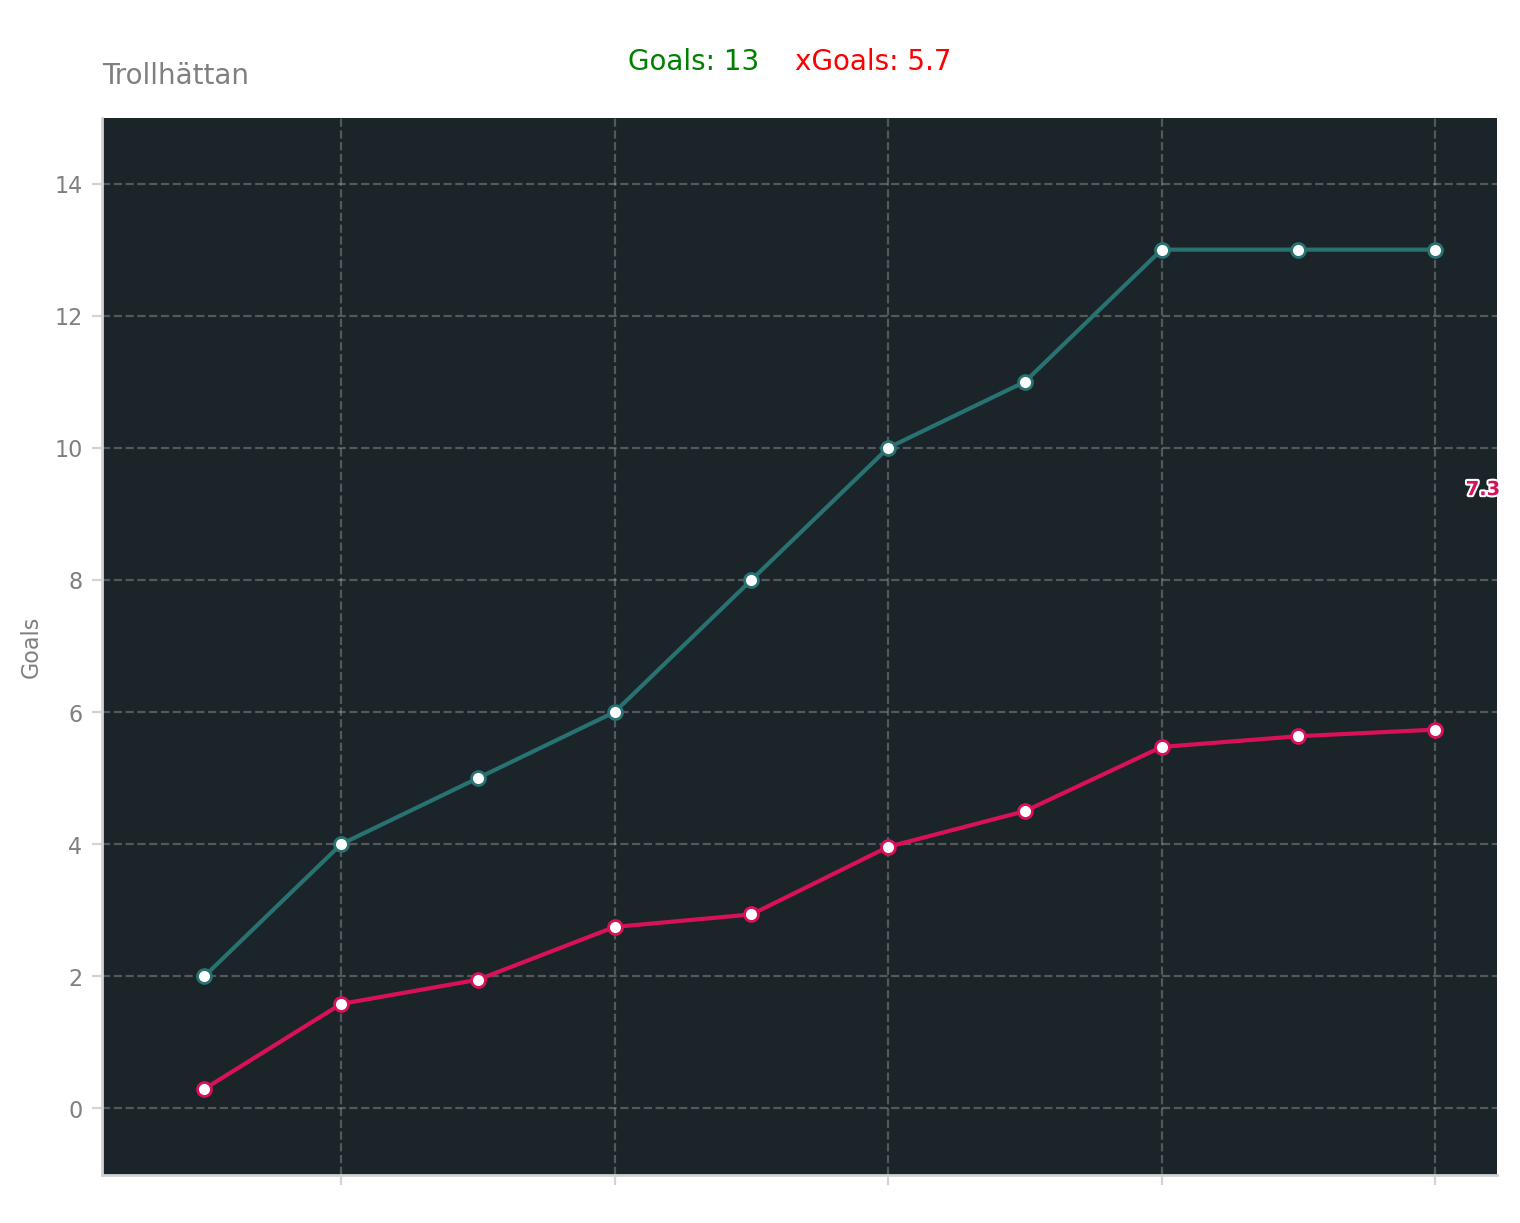

In [148]:
# Insert player name
player_name = 'Alibek Aliev'
player_to_display = player_name

fig = plt.figure(figsize=(9, 7), dpi=200)
nrows = 1
ncols = 1
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig,
    height_ratios=[(1 / nrows) * 2.6 if x % 2 != 0 else (1 / nrows) / 2.6 for x in range(nrows)], hspace=0.2
)

ax = plt.subplot(
    gspec[0, 0],
    facecolor='#1b2429'  # Set the background color to '#1b2429'
)

filtered_df = player_df[player_df['player'] == player_to_display]
if not filtered_df.empty:
    team = filtered_df.iloc[0]['team']
    label_y = True
    print(f"Plotting graph for {player_to_display} ({team})")
    plot_goals_difference(ax, player_to_display, label_y, data=filtered_df)

cumulative_xg = filtered_df['xG'].sum()
cumulative_goals = filtered_df['goals'].sum()
print(f"Cumulative xG for {player_name}: {cumulative_xg:.1f}")
print(f"Cumulative goals for {player_name}: {cumulative_goals:.0f}")

# Truncate player name if too long
max_name_length = 17
truncated_player = player_name[:max_name_length] + '...' if len(player_name) > max_name_length else player_name

fig.text(
    x=0.125, y=0.95,
    s=f'{truncated_player}',
    va='top', ha='left',
    fontsize=14, fontweight='bold', fontfamily='DM Sans', color='white'
)

fig.text(
    x=0.125, y=0.92,
    s=f'{team}',
    va='top', ha='left',
    fontsize=10, fontfamily='DM Sans', color='grey'
)

fig.text(
    x=0.49, y=0.92,
    s=f'Goals: {cumulative_goals:.0f}',
    va='center', ha='right',
    fontsize=10, fontfamily='Karla', color='green'
)

fig.text(
    x=0.5, y=0.92,
    s='\u2758',
    va='center', ha='center',
    fontsize=10, fontfamily='Karla', color='white'
)

fig.text(
    x=0.51, y=0.92,
    s=f'xGoals: {cumulative_xg:.1f}',
    va='center', ha='left',
    fontsize=10, fontfamily='Karla', color='red'
)

fig.text(
    x=0.69, y=0.11,
    s=f'Viz by: Simon Gebrenegus & Alex Eriksson',
    va='center', ha='left',
    fontsize=6, fontfamily='Karla', color='white'
)

plt.savefig(
    r'C:\Users\al.eriksson\Documents\Python\Football\xg_goals_individual.jpg',  # Update the filename and extension
    dpi=600,
    facecolor='#1b2429',  # Set the background color to '#1b2429'
    bbox_inches="tight",
    edgecolor='#1b2429',  # Set the edge color to '#1b2429'
    transparent=False
)

plt.show()
